# Esercitazione 4
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione quattro è raccolto nella cartella `Lab_04`. I codici sono disposti nelle cartelle `Code/4.1, 4.2, 4.3`, relative alle consegne proposte. I risultati notevoli sono invece collocati all'interno della cartella `Results`.

---

La struttura del jupyter notebook è la seguente:

- 4.0 caricamento dei pacchetti e introduzione;
- 4.1 sistemazione del codice di dinamica molecolare: (4.1.1) aggiungendo un metodo che ci permetta di equilibrare il sistema e (4.1.2) implementando la possibilità di riscalare le velocità, così da agevolare la convergenza dell'algoritmo allo stato di equilibrio ricercato;
- 4.2 implementazione di un metodo per misurare le grandezze di interesse e le loro incertezze tramite la media a blocchi;
- 4.3 esecuzione di tre simulazioni, con l'intento di stimare le grandezze termodinamiche nei casi solido, liquido e gas considerando un campione di Argon.


## 4.0 - caricamento dei pacchetti e introduzione

__NB:__ in questa esercitazione abbiamo adottato le unità di misura ridotte, che ho indicato con "[LJ units]". Per riportare i risultati nel sistema di riferimento internazionele utilizziamo gli opportuni fattori di conversione relativi all'Argon.

---

In questa esercitazione vogliamo prendere familiarità con un codice di dinamica molecolare (MD) applicandolo ad un caso specifico in ipotesi di insieme microcanonico. Algoritmi di questo tipo sono pensati per simulare l'evoluzione nel tempo di un sistema di particelle tramite la risoluzione delle equazioni del moto. Tramite la simulazione delle informazioni microscopiche del sistema ($r(t), v(t)$) e l'utilizzo della meccanica statistica, siamo in grado di effettuare misure di grandezze termodinamiche di interesse in questo caso Energia potenziale, cinetica e totale medie per particella: $E_{pot}/N_{par},\, E_{kin}/N_{par},\, E_{tot}/N_{par}$ e la temperatura media del sistema $T$. 

Per simulare le traiettorie percorse dalle particelle abbiamo bisogno di un algoritmo che ci permetta di risolvere le equazioni del moto in modo numerico: abbiamo utilizzato l'algoritmo di Verlet. La comodità di Verlet è che, nota la forma del potenziale (che deve essere fornita come input al programma e deve essere scelta con precisione), possiamo calcolare la nuova posizione delle particelle conoscendo le ultime due posizioni occupate: 

$$ \vec{r}(t+\delta t)= 2\vec{r}(t)-\vec{r}(t-\delta t) + \vec{a}(t)\delta t^2, $$

dove con $t\pm\delta t$ intendiamo i passi successivo e precedente dell'algoritmo in questione.
Questo risultato viene ottenuto sviluppando in serie di Taylor fino al secondo ordine $\vec{r}(t+\delta t)$ e $\vec{r}(t-\delta t)$ e sommando le due espressioni ottenute. L'accelerazione viene calcolata conoscendo la massa delle particelle e utilizzando $\vec{F}=-\nabla V$. 

Tramite la differenza delle $\vec{r}(t+\delta t)$ e $\vec{r}(t-\delta t)$ possiamo infine calcolare anche la velocità a tempo $t$:

$$ \vec{v}(t) \simeq \frac{\vec{r}(t+\delta t) - \vec{r}(t-\delta t)}{2\delta t}, $$

nella quale stiamo trascurando i termini di ordine $O(\delta t^2)$.


--- 

In questa esercitazione abbiamo considerato $N_{par}=108$ particelle, disposte all'interno di uno spazio strutturato in modo periodico tramite un opportuno sistema di _Periodic Boundary Condition_ (PBC). Il potenziale che descrive l'interazione tra le particelle è di tipo Lennard-Jones:

$$ V_{LJ}(\vec{r}) = 4\varepsilon \biggl[\biggl(\frac{\sigma}{r} \biggr)^{12}-\biggl(\frac{\sigma}{r} \biggr)^6 \biggr], $$

che assumiamo venga esercitato tra le particelle entro un limite imposto nella forma di raggio di _cutoff_. Abbiamo inoltre predisposto il sistema alla simulazione impostando le condizioni iniziali fornite nella consegna dell'esercizio, corrispondenti a tre stati dell'Argon (fattori di scala: $\sigma=0.34$nm, $\varepsilon/K_B = 120$K, $m=39.948$amu):

- fase solida (`input.solid`): $\rho^*=1.1,\,\,T^*=0.8,\,\,r_c=2.2$
- fase liquida (`input.liquid`): $\rho^*=0.8,\,\,T^*=1.1,\,\,r_c=2.5$
- fase gassosa (`input.gas`): $\rho^*=0.05,\,\,T^*=1.2,\,\,r_c=5.0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.6, style='whitegrid') 

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [4]:
out_parte_1 = []
colors = ['blue', 'orange', 'purple', 'red']
names  = [r'$E_{pot}$', r'$E_{kin}$', r'$E_{tot}$', 'T']

out_parte_1.append(np.loadtxt("Code/4.1/output_epot.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_ekin.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_etot.dat"))
out_parte_1.append(np.loadtxt("Code/4.1/output_temp.dat"))

#out = np.loadtxt('Code/4.1/')

## 4.1 - Sistemazione del codice

In questa prima parte dell'esercitazione abbiamo aggiunto al codice di dinamica molecolare contenuto in `MolDyn_NVE.cpp/h` alcuni metodi, con l'intenzione di provvedere alla fase iniziale della simulazione di MD, ossia il raggiungimento di una condizione di equlibrio, in cui le traiettorie delle particelle nello spazio delle fasi siano disposte lungo appropriate iper-superfici ad energia costante (stiamo eseguendo la simulazione in regime di sistema micro-canonico). Ecco dunque le modifiche apportate al sistema:

#### Equilibrare il sistema

`Equilibrate_system(int Nequi, double T_i, double T_f, int Nrescale)` è un metodo pensato per simulare una fase di equilibrazione del sistema. Viene eseguito soltanto se la variabile `nstart` contenuta nel file `input.dat` assume valore `true`. In tal caso il programma inizializza il sistema eseguendo `Nequi` passi dell'algoritmo di Verlet. Quando il processo di equilibrazione arriva al passo `Nequi/10` viene eseguito un cambio del valore della temperatura: `T_i -> T_f`. Ho eseguito questa operazione solo nel caso del gas (aiuta il sistema a raggiungere l'equilibrio). All'interno dell'equilibrazione vengono anche riscalate le velocità tramite il metodo che spiego poco più avanti. Al termine di questo processo vengono salvate le ultime due configurazioni del sistema a `Npart=108` particelle e viene cambiato il valore di `nstart` da `true` a `false`. A questo punto vengono implementati `Nstep` passi dell'algoritmo di Verlet, i quali sono poi utilizzati dal metodo `blocking` per effettuare le misure.

#### Riscalare le velocità

`rescale_velocities()` è un metodo nel quale ho implementato un riscalamento delle velocità ad un istante fissato della simulazione. L'idea è che, calcolando la temperatura $$ T(t+dt/2)=\frac{\sum_{i=1}^{N_{part}}|\vec{v}_i (t+dt/2)|^2}{3N_{part}}, \qquad \qquad \text{dove} \qquad \qquad \vec{v}(t+dt/2)=\frac{\vec{r}(t+dt)-\vec{r}(t)}{dt}, $$ sia possibile ricavare un fattore di riscalamento per la temperatura (e dunque anche per la velocità) nel modo seguente: $$ f_s = \biggl[\frac{T^*}{T(t+dt/2)}\biggr]^{1/2}, $$ dove ho indicato con $T^*$ la temperatura ideale che intendiamo raggiungere (che nel caso del gas passa da `T_i` a `T_f` nel corso dell'equilibrazione).

Per effettuare un riscalamento che risponda in modo effettivamente utile al comportamento del sistema ho deciso di ricavare il modulo quadro delle velocità eseguendo una media di questo stesso valore ma registrato nel corso di $N_{kin}$ passi dell'algoritmo. In questo modo si riesce ad evitare che il valore ottenuto sia il risultato di una fluttuazione del sistema (non mi basta una fotografia istantanea per capire a fondo la situazione cinetica del sistema termodinamico). Il numero di passi da prendere in considerazione per eseguire questa media è arbitrario: ho predisposto il metodo in questo modo per poter trattare in modo diverso i singoli casi.

#### Stampare le misure

`Measure(bool print)` è un metodo identico a quello proposto nel codice fornito a lezione, al quale ho aggiunto la possibilità di stabilire se l'utente desidera stampare sui files di output i valori delle misure.

---

In questo primo esercizio ho utilizzato come input i valori contenuti nel file `input.solid`, al quale ho aggiunto la variabile `restart`, impostata con il valore `true` così da procedere con l'equilibrazione del sistema. Ho deciso di eseguire un'equilibrazione di 1000 passi, durante la quale ho effettuato un riscalamento delle velocità ogni 250 passi. In seguito, ho eseguito ulteriori 5000 passi dell'algoritmo, senza effettuare alcun riscalamento. Le misure delle grandezze termodinamiche sono effettuate ogni passo ma stampate su file ogni dieci passi. 

---

__NB:__ combinando i metodi che ho scritto è necessario eseguire il codice una volta sola. Ogni tipo di modifica ai parametri delle simulazioni o della fase di equilibrazione viene fatto prima di avviare l'esecuzione.

### Risultati ottenuti

Nel grafico seguente ho raccolto i valori istantanei delle quattro grandezze termodinamiche misurate.

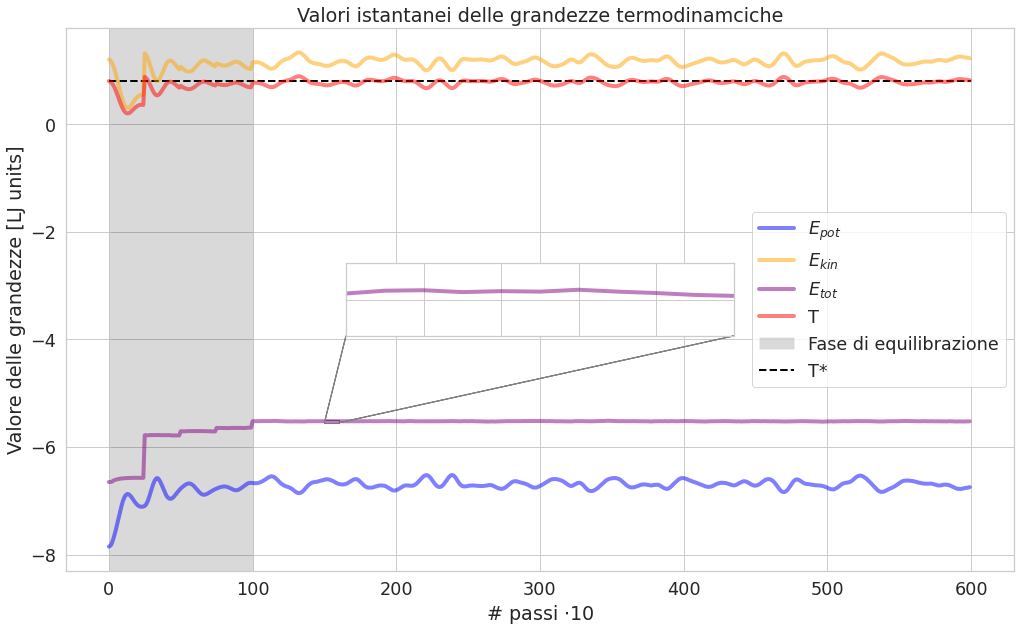

In [5]:
fig, ax = plt.subplots(figsize=[17, 10])
plt.title('Valori istantanei delle grandezze termodinamciche')
plt.xlabel('# passi $\cdot 10$')
plt.ylabel('Valore delle grandezze [LJ units]')

x1, x2, y1, y2 = 150, 160, -5.55, -5.5 
axins = zoomed_inset_axes(ax, zoom=27, loc=10)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)

for i in range(4):
    ax.plot(out_parte_1[i], color=colors[i], alpha=0.5, linewidth=4, linestyle='-', label=names[i])
    axins.plot(out_parte_1[i], color=colors[i], alpha=0.5, linewidth=4, linestyle='-', label=names[i])
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5")
ax.hlines(0.8, 0, 600, color='black', linewidth=2, label='T*', linestyle='--')
ax.axvspan(0, 100, facecolor='black', alpha=0.15, label='Fase di equilibrazione')

ax.legend(loc=5)
plt.show()

__Figura 1:__ nel grafico sono rappresentati gli andamenti dei valori registrati per le quattro grandezze misurate ogni dieci passi dell'algoritmo. Si nota, in modo particolare osservando l'andamento dell'energia totale, il risultato dei riscalamenti delle velocità. Analizzando l'andamento della temperatura si vede inoltre come, dopo una prima fase di stabilizzazione (in cui osserviamo ad esempio un crollo del valore di temperatura ed energia cinetica, di cui parlerò più avanti), il valore oscilli attorno a quello desiderato, rappresentato in grafico con la linea nera tratteggiata. Il numero di passi svolto in questo primo esercizio è molto basso, troppo per poter effettuare una stima delle grandezze utilizzando, ad esempio, il metodo delle medie a blocchi. Nonostante questo, grazie anche alla più semplice trattabilità della fase solida, riusciamo a visualizzare il processo di equilibrazione del sistema.

## 4.2 - Misura delle grandezze con media a blocchi

In questa seconda parte dell'esercitazione abbiamo implementato un metodo per misurare effettivamente i valori delle grandezze di interesse (temperatura, energia cinetica media per particella, energia potenziale media per particella, energia totale media per particella). Nel farlo, abbiamo deciso di utilizzare il metodo `blocking`. Nello specifico, ho scritto il metodo `Blockin_on_MD(int M, int N, string filename)`, tramite cui ho eseguito una media a blocchi, i cui risultati cumulativi per ogni blocco sono salvati nel file `filename`. Il metodo è scritto in modo simile a quello proposto nelle precedenti esercitazioni: le misure (mosse di Verlet) vengono svolte direttamente nel `blocking` e accumulate in variabili opportune, così da evitare che venga occupata inutilmente la memoria del sistema.

Ho eseguito questa nuova versione di codice con gli stessi metodi e parametri utilizzati nell'esercizio 4.1 (ma eseguendo le misure ad ogni passo). Proprio per questa ragione sottolineo che i risultati ottenuti non consistono in una vera e propria misura fatta sul sistema; si tratta di una fase in cui mi sono puramente occupato di valutare il funzionamento della media a blocchi.

In [6]:
ave_res = np.loadtxt("Results/ave_4.1.dat")

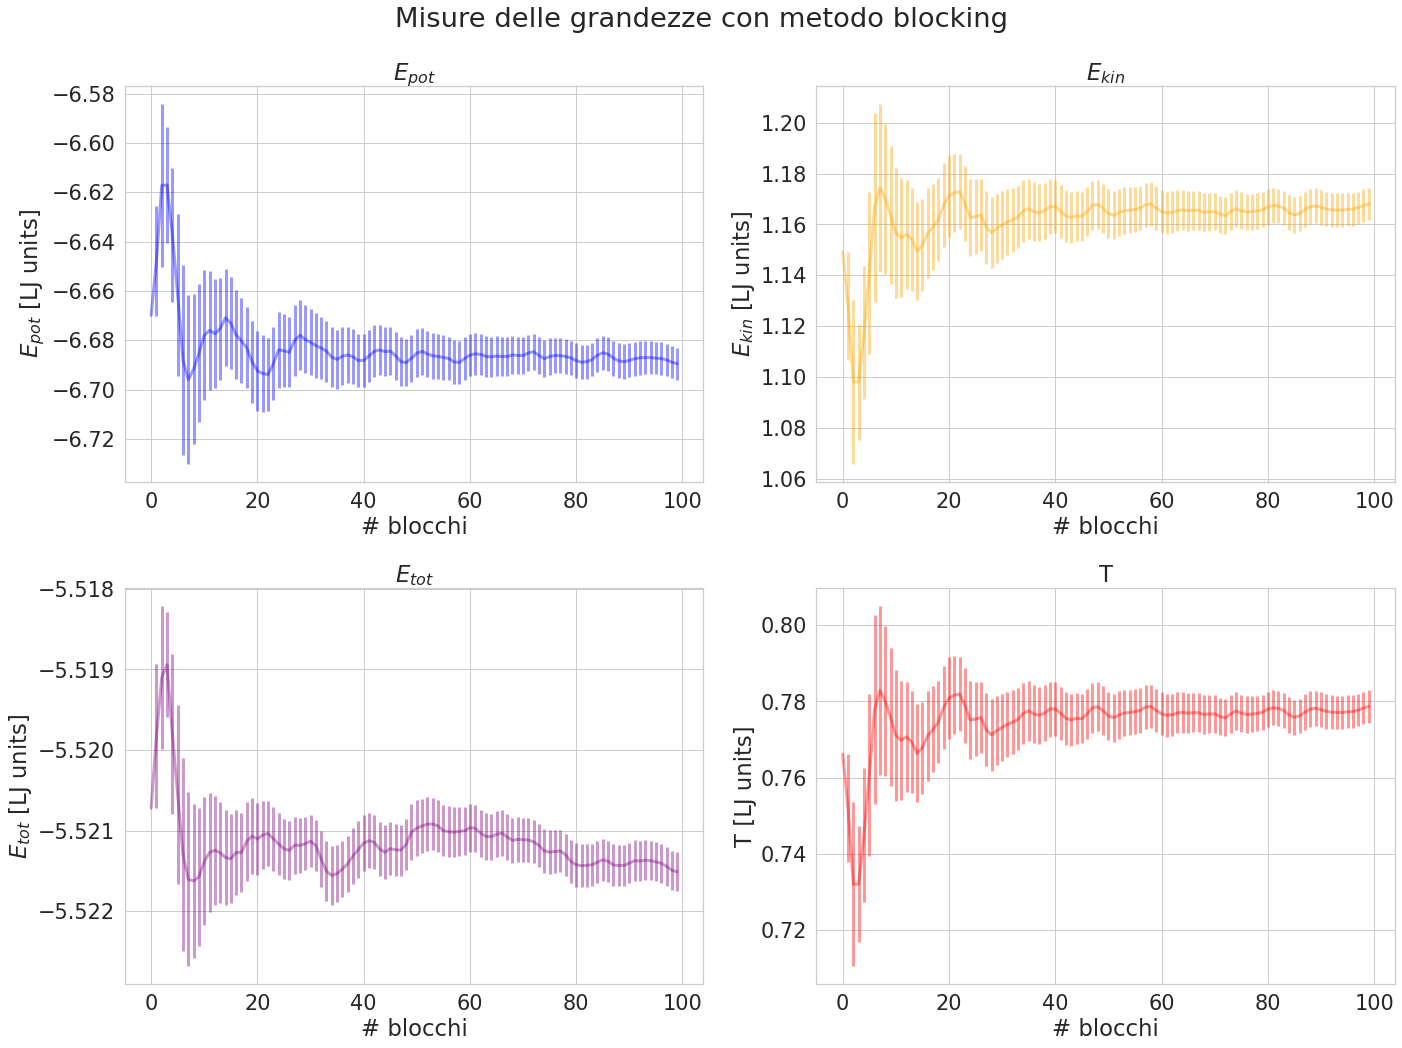

In [7]:
plt.figure(figsize=(20,15))
sns.set_theme(font_scale=1.9, style='whitegrid') 
plt.suptitle('Misure delle grandezze con metodo blocking')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res.T[2*i], yerr=ave_res.T[2*i+1], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+' [LJ units]')
    
plt.tight_layout()

__Figura 2:__ in questa figura sono rappresentati i valori misurati delle grandezze di riferimento in funzione del numero di blocchi. Lo scopo di questa seconda parte di esercizio era verificare il funzionamento del codice che implementa la media a blocchi; a partire da ora inizierò ad effettuare le misure.

## 4.3 - Misura delle grandezze sui tre stati dell'Argon

Come terzo passaggio dell'esercitazione abbiamo infine utilizzato il codice per misurare queste grandezze termodinamiche allo stato di equilibrio per tre fasi diverse dell'Argon ($\sigma=0.34$nm, $\varepsilon/K_B = 120$K, $m=39.948$amu):
- fase solida: $\rho^*=1.1,\,\,T^*=0.8,\,\,r_c=2.2$
- fase liquida: $\rho^*=0.8,\,\,T^*=1.1,\,\,r_c=2.5$
- fase gassosa: $\rho^*=0.05,\,\,T^*=1.2,\,\,r_c=5.0$

A tal fine, il numero di realizzazioni effettuate è maggiore e diverso per ciascuna misura: le fluttuazioni dei valori istantanei delle grandezze (ho preso la temperatura come riferimento) mostrano comportamenti molto diversi nelle tre fasi. La fase solida raggiunge con facilità una condizione che mi sento di definire equilibrata attorno al valore atteso della temperatura (quello che utilizziamo per fissare l'energia del sistema in accordo con l'ipotesi di analisi di un sistema micro-canonico) e presenta fluttuazioni su scale più piccole in termini di passi di Verlet. Anche nel caso del liquido è sufficiente eseguire un numero contenuto di passi di equilibrazione. Nel caso del gas, invece, il discorso è diverso e verrà approfondito nella sezione apposita.

In [12]:
m_equi = 2000

def plot_equilibration(mylist, steps, title, col, T):
    plt.figure(figsize=(28,5))
    plt.suptitle(title)
    plt.subplot(1,3,1)
    plt.plot(mylist[:steps], color=col, linewidth=3, alpha=0.5, label='Primi passi')
    plt.hlines(T, 0, steps, color='black',linewidth=3, label='$T^*$', alpha=0.6, linestyle='--')
    plt.axvspan(0, m_equi, facecolor='black', alpha=0.10, label='Fase di equilibrazione')
    plt.xlabel('# passi')
    plt.ylabel('T [LJ units]')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(mylist[m_equi : m_equi+steps], color=col, linewidth=3, alpha=0.5, label='Passi centrali')
    plt.hlines(T, 0, steps, color='black', linewidth=3, label='$T^*$', alpha=0.6, linestyle='--')
    plt.xlabel('# passi')
    plt.ylabel('T [LJ units]')
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(mylist[-steps:], color=col, linewidth=3, alpha=0.5, label='Ultimi passi')
    plt.hlines(T, 0, steps, color='black', linewidth=3, label='$T^*$', alpha=0.6, linestyle='--')
    plt.xlabel('# passi')
    plt.ylabel('T [LJ units]')
    plt.legend()

In [9]:
path = "Code/4.3/"
istant = []

ist_files = ["T_solid.dat", "T_liquid.dat", "T_gas.dat"]
inp_files = ["input.solid", "input.liquid", "input.gas"]
phase = ['Solido', 'Liquido', "Gas"]

### Fase solida

Per l'analisi della fase solida ho eseguito $N_{equi}=2000$ passi di equilibrazione, riscalando le velocità un totale di cinque volte (ogni 400 passi). Durante la fase di equilibrazione non ho mai variato il valore della temperatura del sistema, impostata come $T^*=0.8$ in fase di inizializzazione. A seguire ho svolto $M = 5\cdot 10^4$ passi di simulazione sui quali ho eseguito una media a blocchi con $N=100$ ($L=500$). Nella figura 3 ho messo a confronto i valori istantanei della temperatura in tre diverse fasi della simulazione per visualizzare l'effettivo raggiungimento dell'equilibrazione. 

In questo esercizio, come nei successivi, ho salvato i valori istantanei della temperatura corrispondenti __ad ogni__ passo dell'algoritmo di MD.

In [10]:
temp_solid = np.loadtxt("Results/T_solid.dat")
ave_res_solid = np.loadtxt("Results/ave_solid.dat")

len(temp_solid)

52000

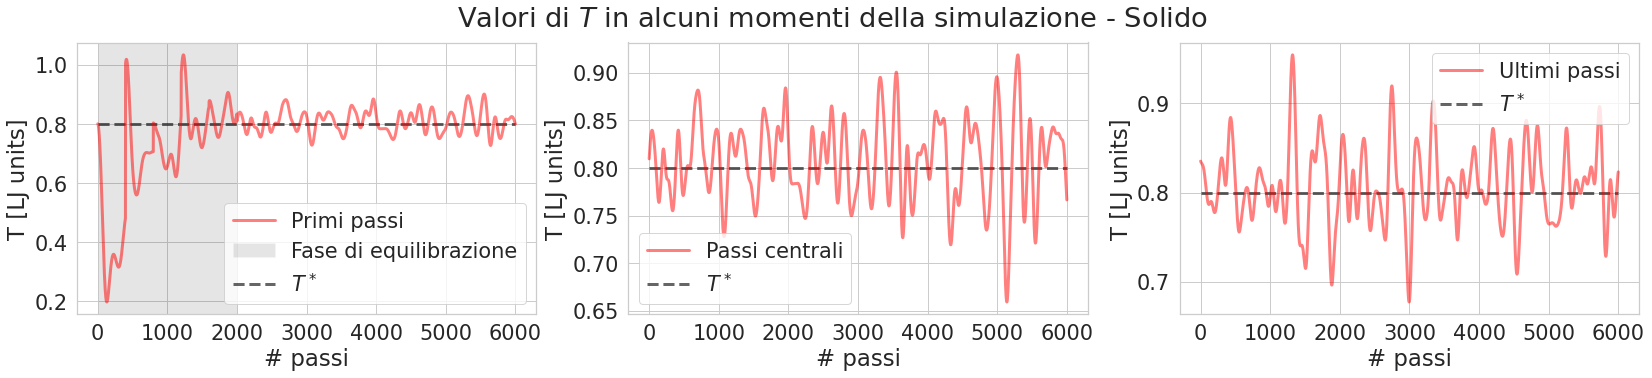

In [13]:
plot_equilibration(temp_solid, 6000, 'Valori di $T$ in alcuni momenti della simulazione - Solido', 'red', 0.8)

__Figura 3:__ a sinistra, i primi seimila valori della temperatura misurati, passo per passo, durante la simulazione. Al centro, i primi seimila passi successivi alla fase di equilibrazione. A destra, gli ultimi seimila valori della temperatura. In primo luogo, notiamo che al sistema sono sufficienti i duemila passi di equilibrazione proposti: dopo una serie di assestamenti, anche dovuti ai riscalamenti delle velocità, il valore della temperatura inizia ad oscillare attorno al valore $T^*=0.8$, cioè quello impostato come temperatura desiderata. Notiamo inoltre che le oscillazioni registrate dalla temperatura del sistema appena dopo la fase di equilibrazione sono paragonabili a quelle della fase finale della simulazione. In secondo luogo, notiamo che il grafico della temperatura ha la tendenza ad abbattere il suo valore nella fase iniziale. Penso che questo comportamento sia dovuto al fatto che la configurazione iniziale delle posizioni corrisponda ad un reticolo perfettamente cristallino (cosa che invece non è vera all'equilibrio a $T=0.8$). Quando chiediamo al sistema di fornirci una stima della temperatura nella fase iniziale, esso non ha ancora raggiunto una condizione di equilibrio, perciò risulta più "cristallizzato" di quanto non lo sia poi in fase di simulazione avviata. Per questa ragione, se non lasciamo al sistema il tempo di disordinarsi abbastanza, il valore della temperatura, che è stimato a partire dalle posizioni delle particelle.

Nel grafico seguente ho riportato i valori delle misure delle grandezze di interesse in funzione del numero di blocchi. L'ho fatto convertendo da unità di Lennard-Jones a unità di misura del sistema internazionale. Per far questo ho calcolato:

$$ E = \varepsilon E^*, \qquad \sigma_E = \frac{\partial E}{\partial E^*} \sigma_E^* = \varepsilon E^*, $$

$$ T = \frac{\varepsilon}{K_B} T^*, \qquad \sigma_T = \frac{\varepsilon}{K_B} \sigma_T^*, \qquad \,\,$$

dove le prime due relazioni sono valide per tutte e tre le energie stimate.

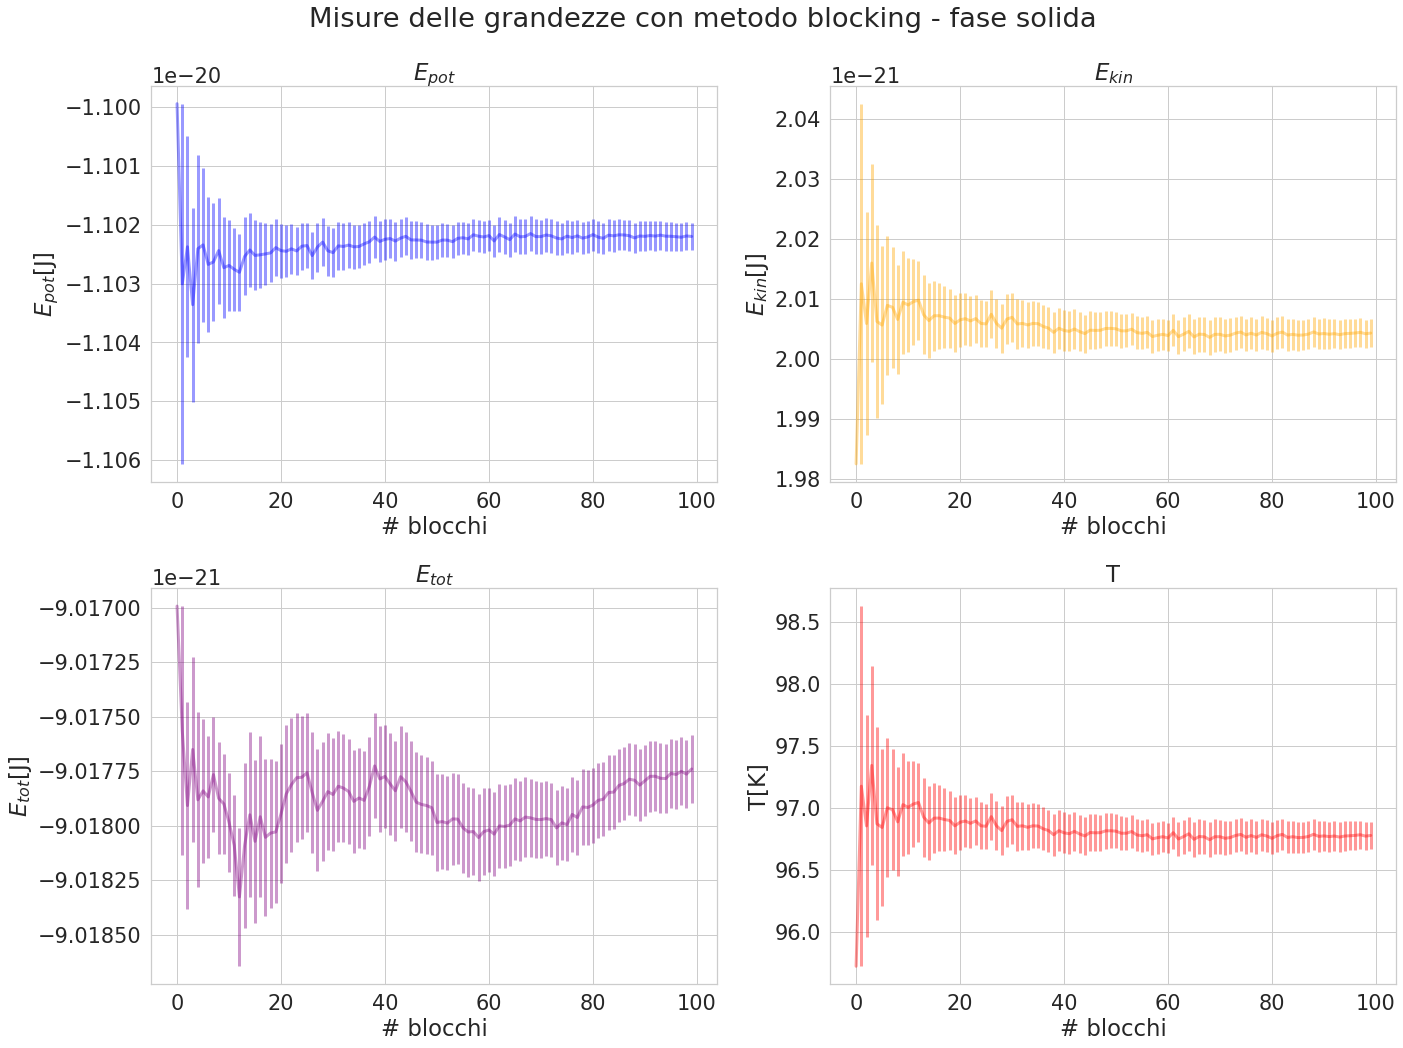

In [14]:
# fattori di conversione

K_B = 1.380649e-23
eps = 120*K_B
m   = 39.948*1.66054e-27
T_star = 120*0.8

fs = [eps, eps, eps, eps/K_B]
SI = ['[J]', '[J]', '[J]', '[K]']

# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase solida')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_solid.T[2*i]*fs[i], yerr=ave_res_solid.T[2*i+1]*fs[i], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+SI[i])
    
plt.tight_layout()

In [15]:
# errore relativo calcolato utilizzando le u.d.m. LJ

print('Valore finale di temperatura ottenuto: ',ave_res_solid.T[6][99])
print('Errore relativo: ', (np.abs(ave_res_solid.T[6][99]-0.8))/0.8)

Valore finale di temperatura ottenuto:  0.80649053
Errore relativo:  0.008113162499999993


__Figura 4:__ misura delle quattro grandezze di interesse in funzione del numero di blocchi. I quattro grafici presentano le grandezze in unità di misura del sistema internazionale. L'andamento dei valori delle misure risulta piuttosto stabile. Questo mi porta a pensare che le misure effettuate sui blocchi siano calcolate utilizzando realizzazioni che non presentano grandi oscillazioni attorno al valore di equilibrio (come vediamo anche in figura 3). Volendo effettuare un calcolo: i risultati ottenuti presentano una temperatura $T=0.806$, dunque un errore relativo $\Delta T/T = (0.806-0.8)/0.8=0.008$, ossia dello 0.8%.

### Fase liquida

Per l'analisi della fase liquida ho eseguito $N_{equi}=2000$ passi di equilibrazione, riscalando le velocità un totale di cinque volte (ogni 400 passi). Durante la fase di equilibrazione non ho mai variato il valore della temperatura del sistema, impostata come $T^*=1.1$ in fase di inizializzazione. A seguire ho svolto $M = 5\cdot 10^4$ passi di simulazione sui quali ho eseguito una media a blocchi con $N=100$ ($L=500$).
Nonostante i parametri con cui ho predisposto la simulazione e la misura tramite _blocking_ siano gli stessi utilizzati per la fase solida, ci troviamo a trattare un sistema che presenta una condizione di equilibrio più instabile rispetto al precedente (ma ce lo aspettiamo dato che passiamo da un solido ad un liquido).

In [16]:
temp_liquid = np.loadtxt("Results/T_liquid.dat")
ave_res_liquid = np.loadtxt("Results/ave_liquid.dat")

len(temp_liquid)

52000

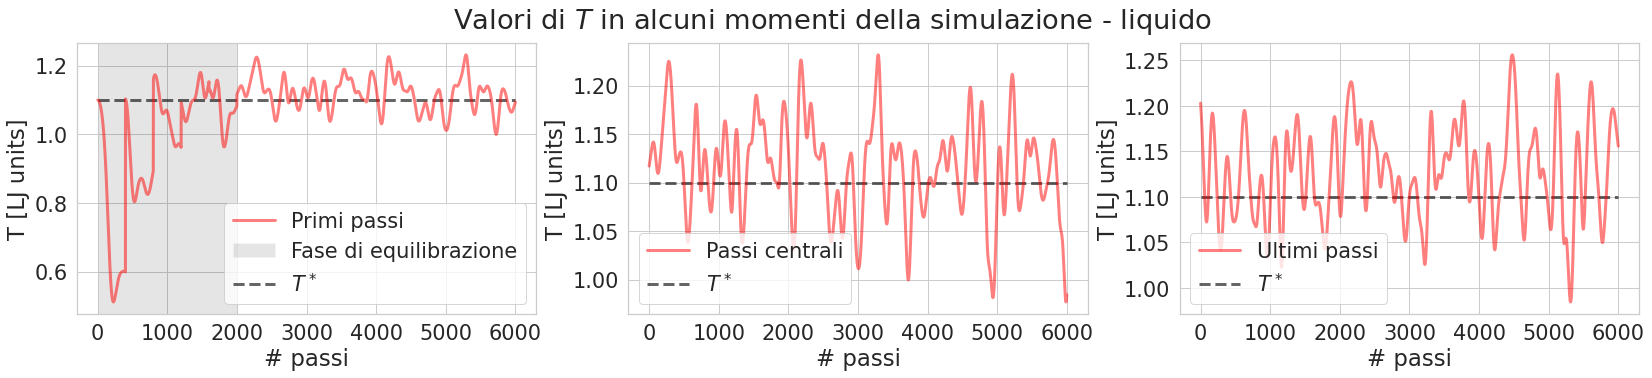

In [17]:
plot_equilibration(temp_liquid, 6000, 'Valori di $T$ in alcuni momenti della simulazione - liquido', 'red', 1.1)

__Figura 5:__ la rappresentazione è analoga a quella in figura 3. Notiamo gli stessi due comportamenti registrati nel caso della fase solida: al sistema sono sufficienti duemila passi per raggiungere una fase di equilibrio che viene mantenuta nel corso della simulazione. Anche in questo caso i primi seimila passi successivi alla fase di equilibrazione mostrano oscillazioni di temperatura paragonabili a quelle registrati negli ultimi seimila. Inoltre, come già visto in precedenza, notiamo che la temperatura  del sistema tende a crollare verso il basso nella fase iniziale dell'equilibrazione. Penso che il motivo sia lo stesso riportato nel commento precedente (aggravato dal fatto che vogliamo che il sistema raggiunga un equilibrio ad una temperatura ancora maggiore $T^*=1.1$).

A seguire, le stime delle grandezze tramite la media a blocchi.

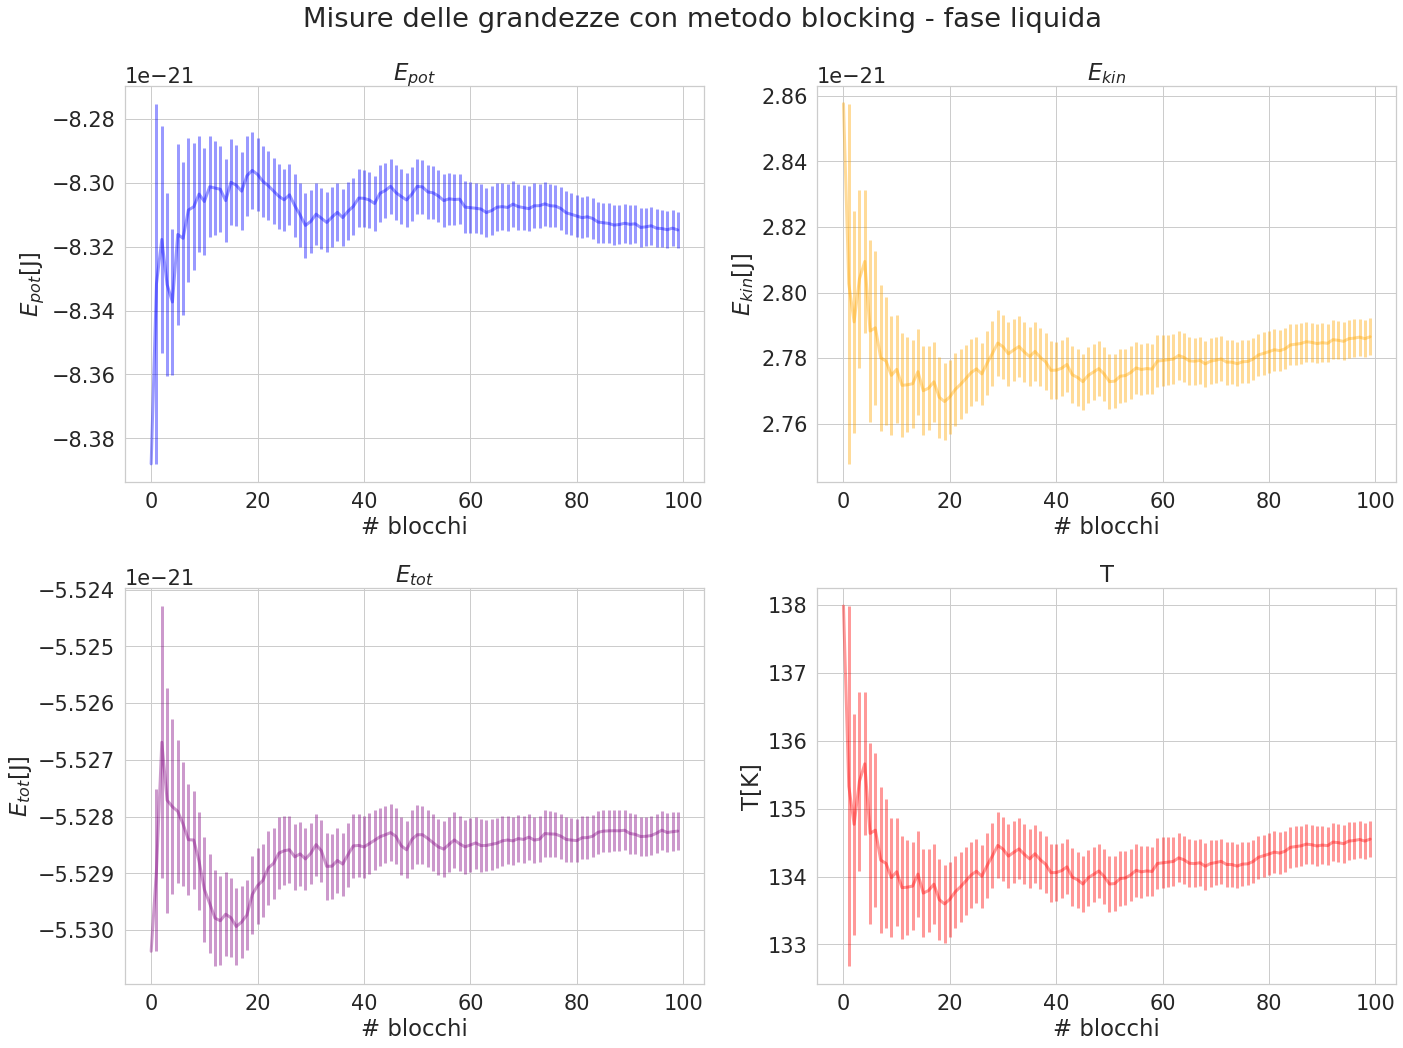

In [18]:
# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase liquida')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_liquid.T[2*i]*fs[i], yerr=ave_res_liquid.T[2*i+1]*fs[i], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+SI[i])
    
plt.tight_layout()

In [19]:
print('Valore finale di temperatura ottenuto: ',ave_res_liquid.T[6][99])
print('Errore relativo: ', (np.abs(ave_res_liquid.T[6][99]-1.1))/1.1)

Valore finale di temperatura ottenuto:  1.1212564
Errore relativo:  0.019323999999999956


__Figura 6:__ stime delle grandezze di interesse in funzione del numero di blocchi e in unità di misura del sistema internazionale. Questa volta registriamo valori un po' meno stabili delle misure progressive e un errore relativo calcolato rispetto al valore target della temperatura $\Delta T/T$ del 2% circa.

### Fase gassosa

Per quanto riguarda il gas ho dovuto effettuare simulazioni di lunghezza differente. Innanzi tutto ho notato che le performance delle simulazioni miglioravano utilizzando, al posto del file `config.0` come input per le posizioni iniziali delle particelle, quello ottenuto al termine della simulazione effettuata per la fase liquida. L'ho chiamato `liquid.0` e l'ho impostato come configurazione di partenza.

In secondo luogo, ho notato che lanciando la simulazione utilizzando la sola temperatura di input proposta nella consegna non ero in grado di portare il sistema ad oscillare attorno alla temperatura target. Inoltre, il valore della temperatura tendeva ad aumentare subito. 

Per affrontare queste problematiche, ho deciso innanzi tutto di migliorare il metodo di riscalamento (poi ho comunque utilizzato questo metodo anche nelle precedenti due simulazioni relative a solido e liquido e in cui inizialmente calcolavo il valore delle velocità al quadrato in un solo istante della simulazione), implementandolo nel modo che ho spiegato in precedenza. Come seconda cosa, ho deciso di impostare la temperatura iniziale ad un valore più basso di quella target. Nello specifico, ho scelto `T_i=0.8`. Ho lasciato evolvere il sistema con questa temperatura per una durata di `Nequi/10` passi. In questo caso ho eseguito un'equilibrazione di `Nequi = 45'000` passi, perciò `4500` di questi sono stati svolti a temperatura di 0.8. Ho riscalato le velocità quindici volte a distanza regolare nel corso dell'equilibrazione. 

Successivamente, per poter trattare un sistema che (in modo evidente dalle prime simulazioni tentate) è sottoposto a fluttuazioni su scala molto più grande dei casi solido e liquido, ho deciso di effettuare le misure su un totale di $M=10^6$ passi di Verlet, suddivisi su $N=100$ blocchi ($L=10^4$).

In [20]:
temp_gas = np.loadtxt("Results/T_gas.dat")
ave_res_gas = np.loadtxt("Results/ave_gas.dat")

len(temp_gas)

1045000

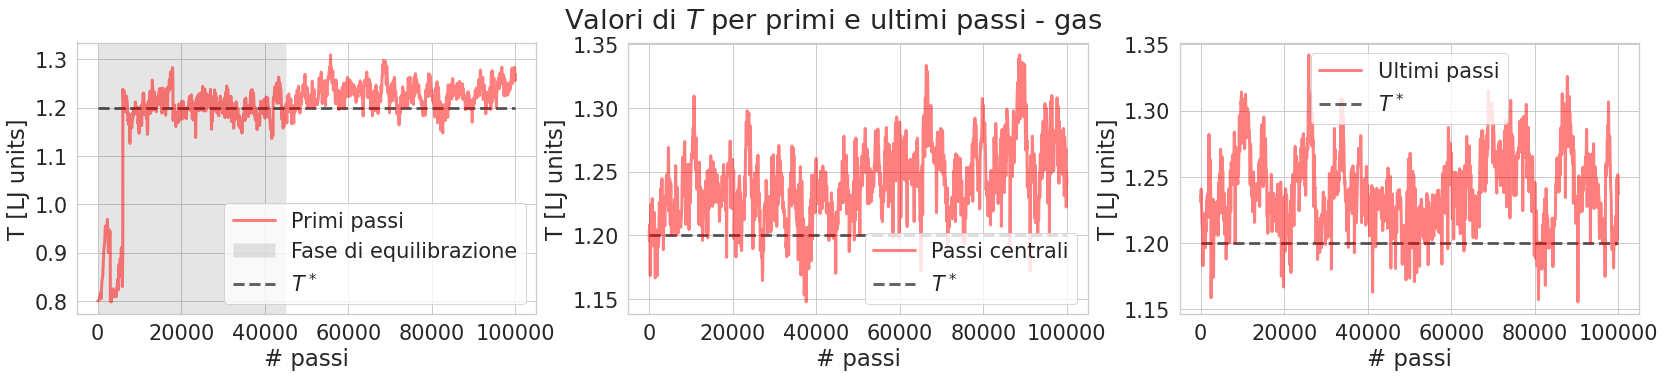

In [21]:
m_equi = 45000
plot_equilibration(temp_gas, 100000, 'Valori di $T$ per primi e ultimi passi - gas', 'red', 1.2)

__Figura 7:__ grafico analogo ai casi solido e liquido. A sinistra, vediamo la fase di equilibrazione del sistema. Al centro e a destra possiamo notare come le oscillazioni del sistema si assestino attorno ad un valore di temperatura di poco superiore a quello target, ma che mantengono la la scala tipica di oscillazione. Ritengo che per effettuare una stima più precisa delle grandezze di interesse sarebbe opportuno eseguire nuove simulazioni di lunghezza ancora maggiore, testare un maggior numero di temperature iniziali e aumentare il numero di passi di Verlet che vengono presi in considerazione per la stima della velocità media quadrata in fase di riscalamento delle velocità.

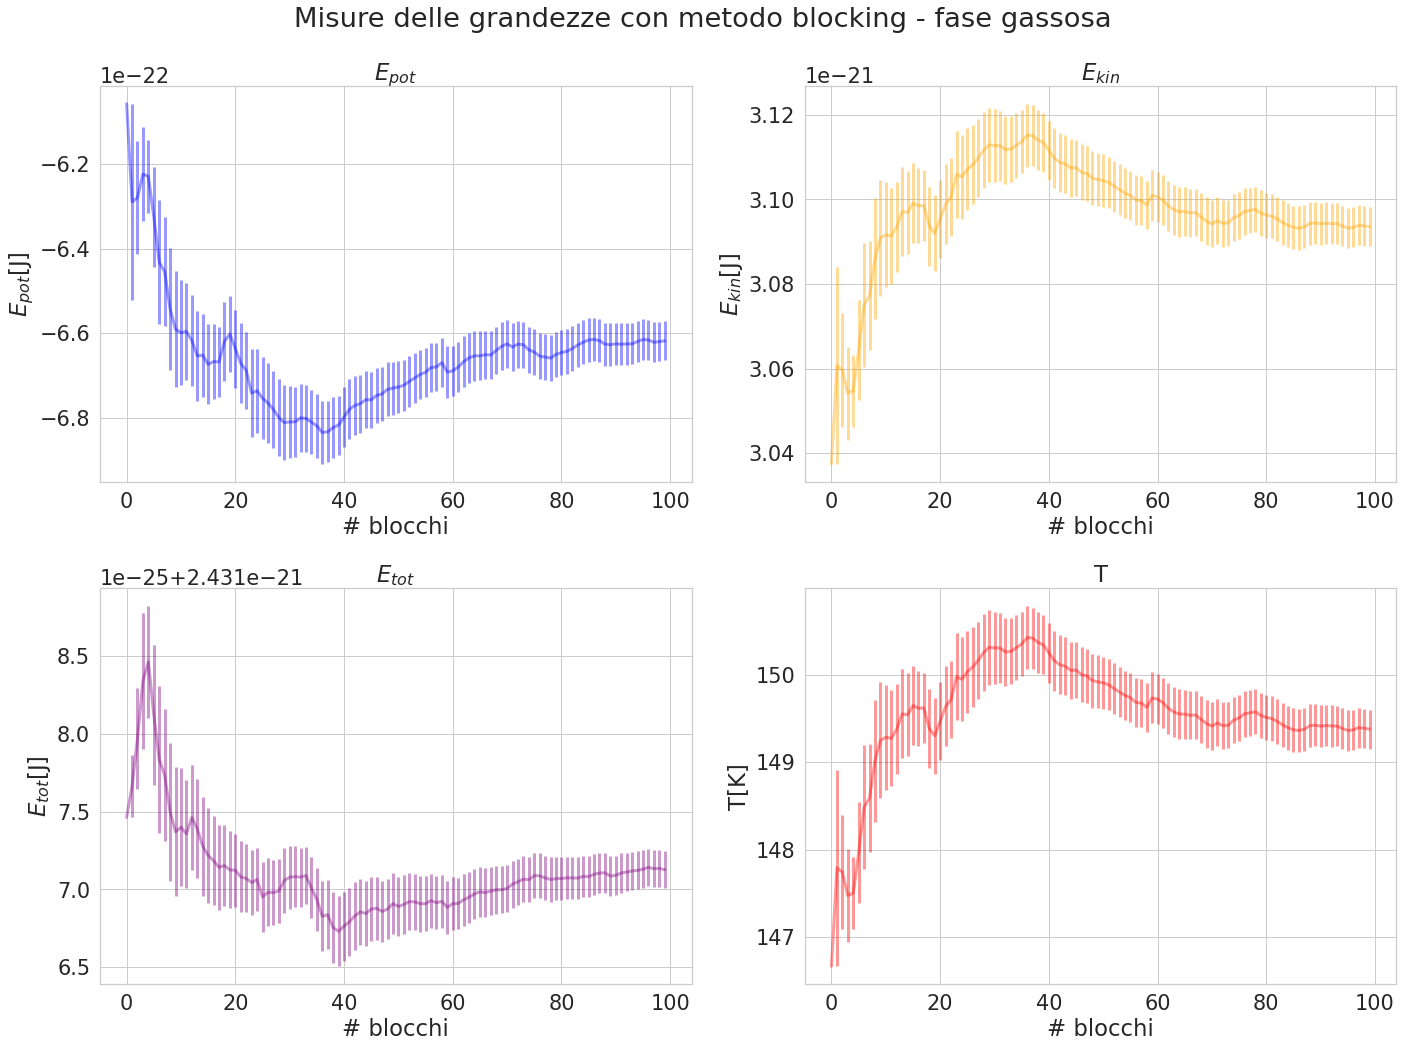

In [22]:
# plots

plt.figure(figsize=(20,15))
plt.suptitle('Misure delle grandezze con metodo blocking - fase gassosa')
x = np.arange(100)

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(names[i])
    plt.errorbar(x, ave_res_gas.T[2*i]*fs[i], yerr=ave_res_gas.T[2*i+1]*fs[i], color=colors[i], alpha=0.4, linewidth=3)
    plt.xlabel('# blocchi')
    plt.ylabel(names[i]+SI[i])
    
plt.tight_layout()

In [23]:
print('Valore finale di temperatura ottenuto: ',ave_res_gas.T[6][99])
print('Errore relativo: ', (np.abs(ave_res_gas.T[6][99]-1.2))/1.2)

Valore finale di temperatura ottenuto:  1.244805
Errore relativo:  0.03733749999999999


__Figura 8:__ andamento dei valori delle misure delle quattro grandezze in funzione del numero di blocchi e in unità di misura del sistema internazionale. In questo caso abbiamo ottenuto un $\Delta T/T \sim $ 4%. Vediamo come le misure iterative non siano apprezzabilmente stabili attorno ad un valore specifico fino al blocco 80. Questo mi spinge a credere che sia necessario prolungare le simulazioni, magari aumentando il numero di blocchi con cui effettuo la misura. Ancora, si potrebbero cercare dei valori di temperatura iniziale e parametri di equilibrazione che mi permettano di raggiungere una condizione di equilibrio in modo più preciso e meno instabile.